In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import os

In [2]:
filename = '../data/ple_chirality/BachiloAssign.dat'

# カイラリティとPLEピークデータの読み込み

In [3]:
chiraldata = []
with open(filename, 'r') as f:
    match_pattern = r'^\s*(#.*|)$'
    line = f.readline()
    while line:
        match = re.match(match_pattern, line)
        if not match:
            chiraldata.append([float(x) for x in line.split()])

            # Convert the first two columns to integers
            for idx in range(len(chiraldata[-1])):
                if idx <= 1:
                    chiraldata[-1][idx] = int(chiraldata[-1][idx])
            ###########################################
        line = f.readline()

print(chiraldata)

[[5, 4, 0.62, 1.488, 2.567, 26.32950349, 1.725134409], [6, 4, 0.69, 1.42, 2.134, 23.41322445, 1.502816901], [9, 1, 0.76, 1.359, 1.789, 5.208719103, 1.316409124], [8, 3, 0.78, 1.302, 1.87, 15.2953443, 1.43625192], [6, 5, 0.76, 1.272, 2.187, 26.9955084, 1.719339623], [7, 5, 0.83, 1.212, 1.925, 24.50363346, 1.588283828], [10, 2, 0.88, 1.177, 1.689, 8.948275565, 1.435004248], [9, 4, 0.92, 1.126, 1.722, 17.4801702, 1.529307282], [8, 4, 0.84, 1.114, 2.112, 19.10660535, 1.895870736], [7, 6, 0.89, 1.105, 1.916, 27.4570761, 1.733936652], [9, 2, 0.81, 1.088, 2.25, 9.826429816, 2.068014706], [12, 1, 0.99, 1.059, 1.556, 3.963234967, 1.46931067], [8, 6, 0.97, 1.058, 1.732, 25.28499605, 1.63705104], [11, 3, 1.01, 1.036, 1.565, 11.741531, 1.510617761], [9, 5, 0.98, 0.997, 1.848, 20.63300108, 1.853560682], [10, 3, 0.94, 0.992, 1.959, 12.73052779, 1.974798387], [10, 5, 1.05, 0.992, 1.577, 19.10660535, 1.589717742], [11, 1, 0.92, 0.982, 2.029, 4.306619096, 2.066191446], [8, 7, 1.03, 0.979, 1.703, 27.795

# 実際に取れたPLデータの読み込み

In [4]:
data_dir  = '../data/pldata'

In [5]:
rawdatadict = {}
for filename in os.listdir(data_dir):
    exictelength = filename.split('_')[0]
    rawdatadict[exictelength] = []
    with open(os.path.join(data_dir, filename), 'r') as f:
        match_pattern = r'^\s*(#.*|)$'
        line = f.readline()
        while line:
            match = re.match(match_pattern, line)
            if not match:
                rawdatadict[exictelength].append([float(x) for x in line.split(',')])
            line = f.readline()
print(rawdatadict)


{'650': [[941.7710775862068, 5.0], [942.760172413793, 43.0], [943.7492672413794, -26.0], [944.7383620689656, 9.0], [945.7274568965516, -4.0], [946.7165517241378, 315.0], [947.705646551724, 718.0], [948.6947413793101, 789.0], [949.6838362068963, 1289.0], [950.6729310344826, 2234.0], [951.6620258620688, 2751.0], [952.6511206896552, 3009.0], [953.6402155172414, 3346.0], [954.6293103448277, 3793.0], [955.6184051724139, 4087.0], [956.6074999999998, 4207.0], [957.5965948275862, 4224.0], [958.5856896551724, 4243.0], [959.5747844827586, 4256.0], [960.5638793103446, 4265.0], [961.552974137931, 4212.0], [962.5420689655172, 4128.0], [963.5311637931034, 3986.0], [964.5202586206896, 3781.0], [965.5093534482758, 3599.0], [966.4984482758621, 3403.0], [967.487543103448, 3251.0], [968.4766379310344, 3126.0], [969.4657327586206, 2936.0], [970.4548275862069, 2811.0], [971.4439224137931, 2651.0], [972.4330172413793, 2576.0], [973.4221120689656, 2462.0], [974.4112068965518, 2487.0], [975.4003017241379, 247

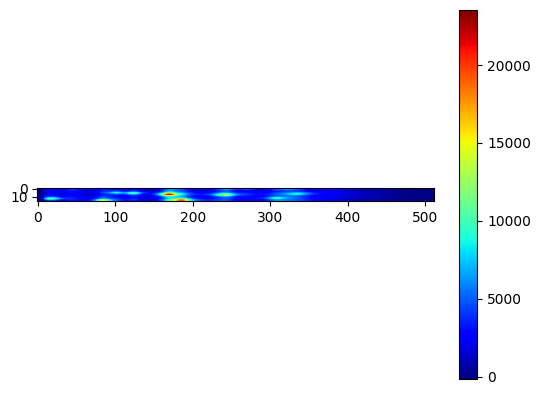

In [6]:
d1_data = []
for key in rawdatadict:
    temp = []
    for data in rawdatadict[key]:
        temp.append(data[1])
    d1_data.append(temp)
d1_datal = d1_data[::-1]#PLEマップの原点は左下．画像の原点は左上．
d1_data = torch.tensor(d1_datal)
plt.imshow(d1_data, cmap='jet')
plt.colorbar()
plt.show()



In [7]:
def plot10x(data: torch.Tensor) -> None:
    pltdata = []
    for d in data:
        for _ in range(10):
            pltdata.append(d)
    plt.imshow(pltdata, cmap='jet')
    plt.colorbar()
    plt.show()

torch.Size([160, 512])


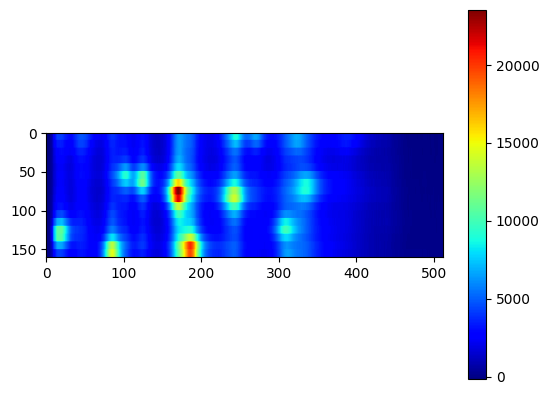

In [8]:
d2_data = []
for d1slice in d1_datal:
    for _ in range(10):
        d2_data.append(d1slice)

d2_data = torch.tensor(d2_data)
print(d2_data.shape)
plot10x(d1_data)

# 畳み込み層による平滑化

In [9]:
class convfilter(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(10,3), stride=1, padding="same")

    def forward(self, x):
        x = self.conv1(x)
        return x

In [10]:
test = convfilter()
for param in test.parameters():
    print(param)
    param.requires_grad = False

print(test.conv1.weight)
print(test.conv1.bias)

Parameter containing:
tensor([[[[ 0.1217,  0.0928, -0.1727],
          [-0.1240, -0.0005,  0.0319],
          [-0.0712, -0.0435,  0.0575],
          [-0.0228,  0.0576, -0.1515],
          [ 0.0109,  0.1419, -0.0557],
          [-0.1418,  0.0157,  0.1111],
          [-0.0302, -0.1350,  0.0327],
          [-0.0787, -0.1187, -0.0909],
          [ 0.0406,  0.0345, -0.1432],
          [-0.0870,  0.1543,  0.0333]]]], requires_grad=True)
Parameter containing:
tensor([-0.0896], requires_grad=True)
Parameter containing:
tensor([[[[ 0.1217,  0.0928, -0.1727],
          [-0.1240, -0.0005,  0.0319],
          [-0.0712, -0.0435,  0.0575],
          [-0.0228,  0.0576, -0.1515],
          [ 0.0109,  0.1419, -0.0557],
          [-0.1418,  0.0157,  0.1111],
          [-0.0302, -0.1350,  0.0327],
          [-0.0787, -0.1187, -0.0909],
          [ 0.0406,  0.0345, -0.1432],
          [-0.0870,  0.1543,  0.0333]]]])
Parameter containing:
tensor([-0.0896])


In [11]:
test.conv1.weight = nn.Parameter(torch.ones_like(test.conv1.weight))
test.conv1.bias = nn.Parameter(torch.zeros_like(test.conv1.bias))

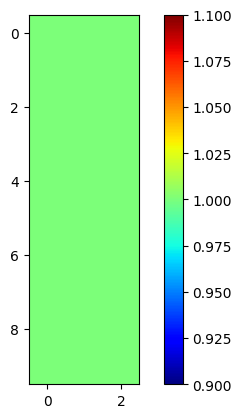

In [12]:
plt.imshow(test.conv1.weight.squeeze(0).squeeze(0).detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()

c:\Users\maruk\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv2d(input, weight, bias, self.stride,


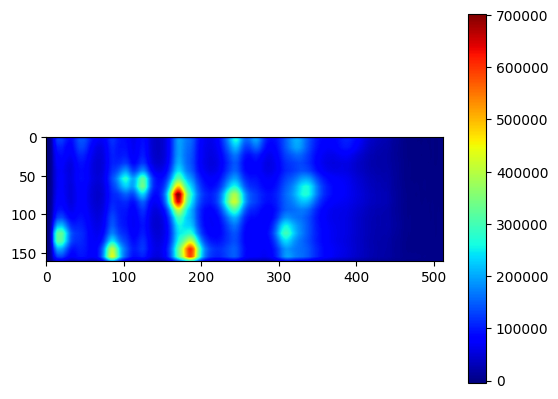

In [13]:
d2_datafiltered = test(d2_data.unsqueeze(0).unsqueeze(0))
plt.imshow(d2_datafiltered.squeeze(0).squeeze(0).detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()

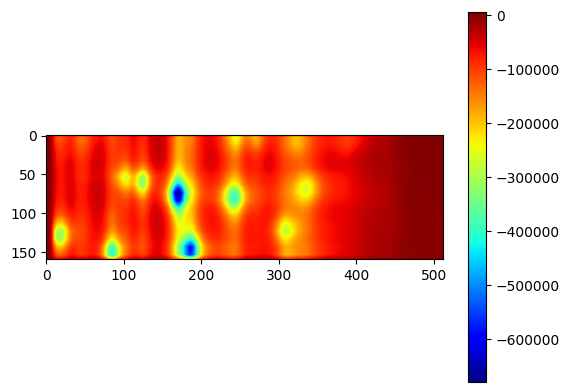

In [14]:
minused = d2_data - d2_datafiltered
plt.imshow(minused.squeeze(0).squeeze(0).detach().numpy(), cmap='jet')
plt.colorbar()

# プーリング層による平滑化

In [15]:
class poolingfilter(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.pool1 = nn.MaxPool2d(kernel_size=(3,31), stride=1, padding=(1,15))

    def forward(self, x):
        x = self.pool1(x)
        return x

In [16]:
poolfilter = poolingfilter()

torch.Size([1, 1, 16, 512])


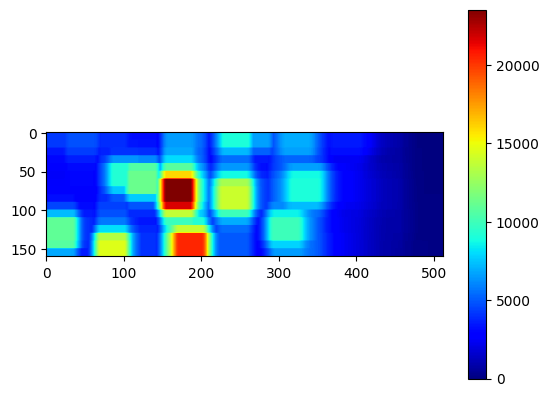

In [17]:
d1_datafiltered = poolfilter(d1_data.unsqueeze(0).unsqueeze(0))
print(d1_datafiltered.shape)
plot10x(d1_datafiltered.squeeze(0).squeeze(0))

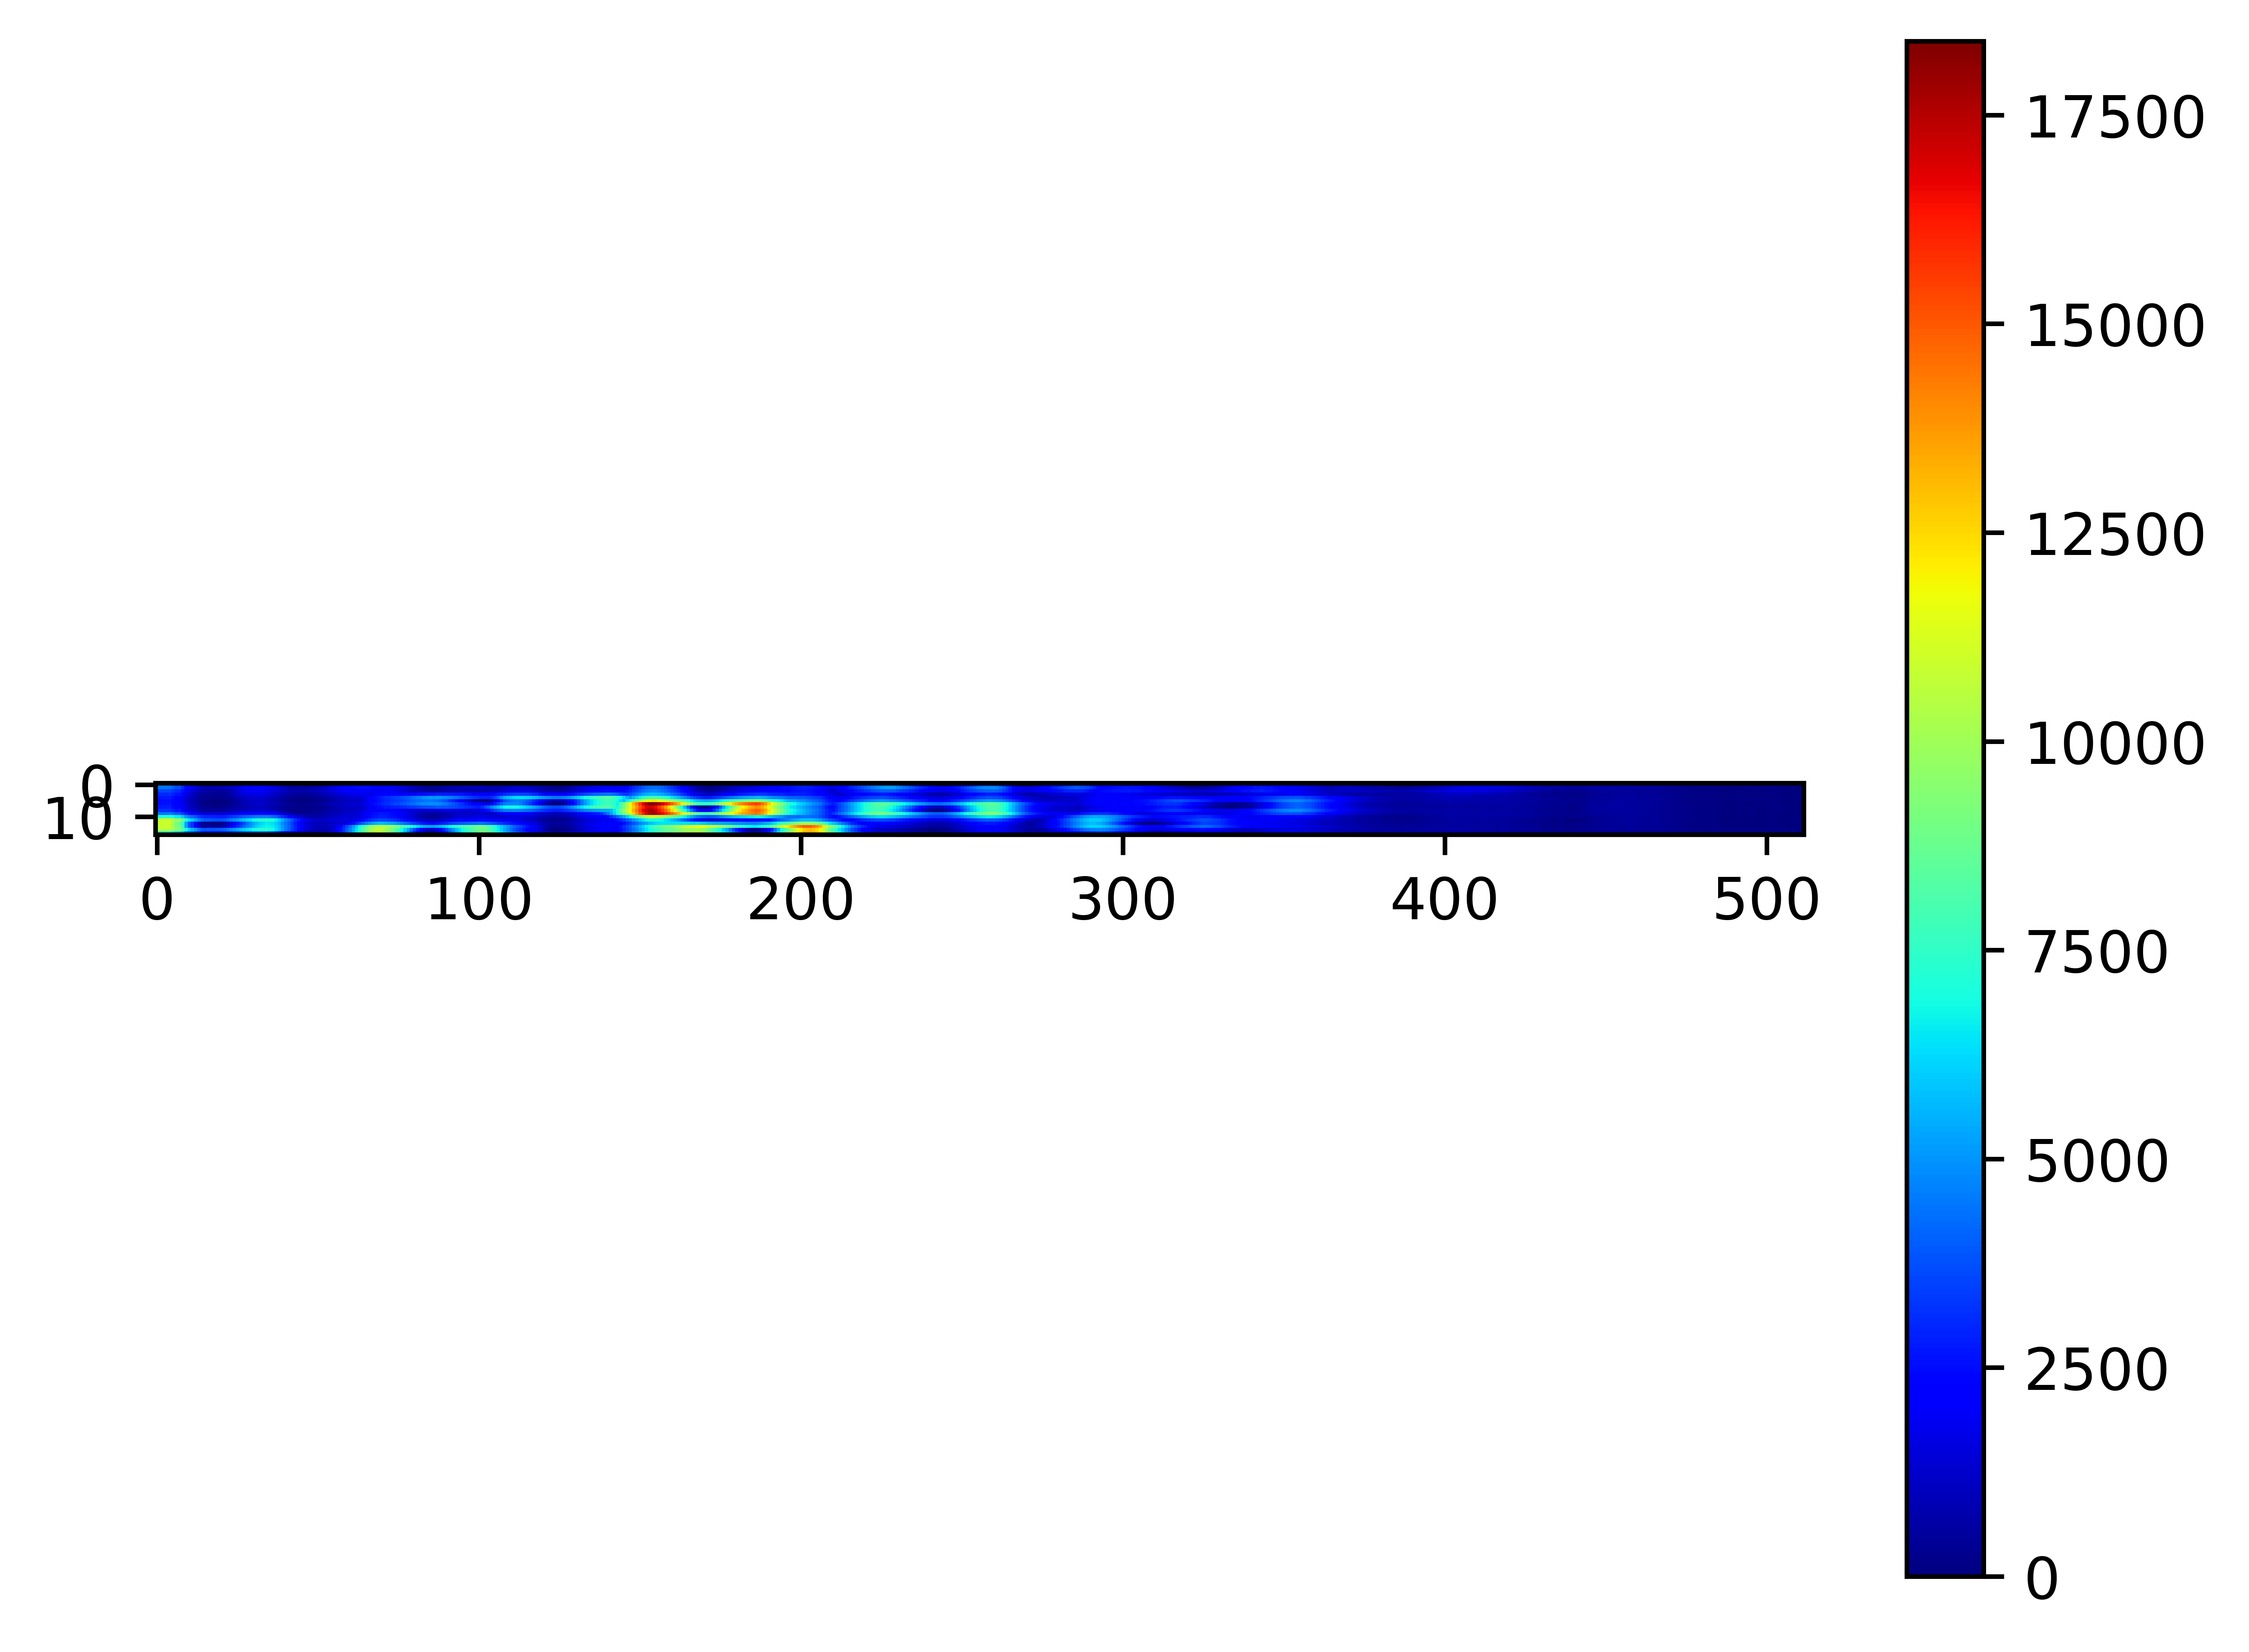

In [18]:
minused = d1_datafiltered - d1_data
plt.figure(dpi=1000)
plt.imshow(minused.squeeze(0).squeeze(0).detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()

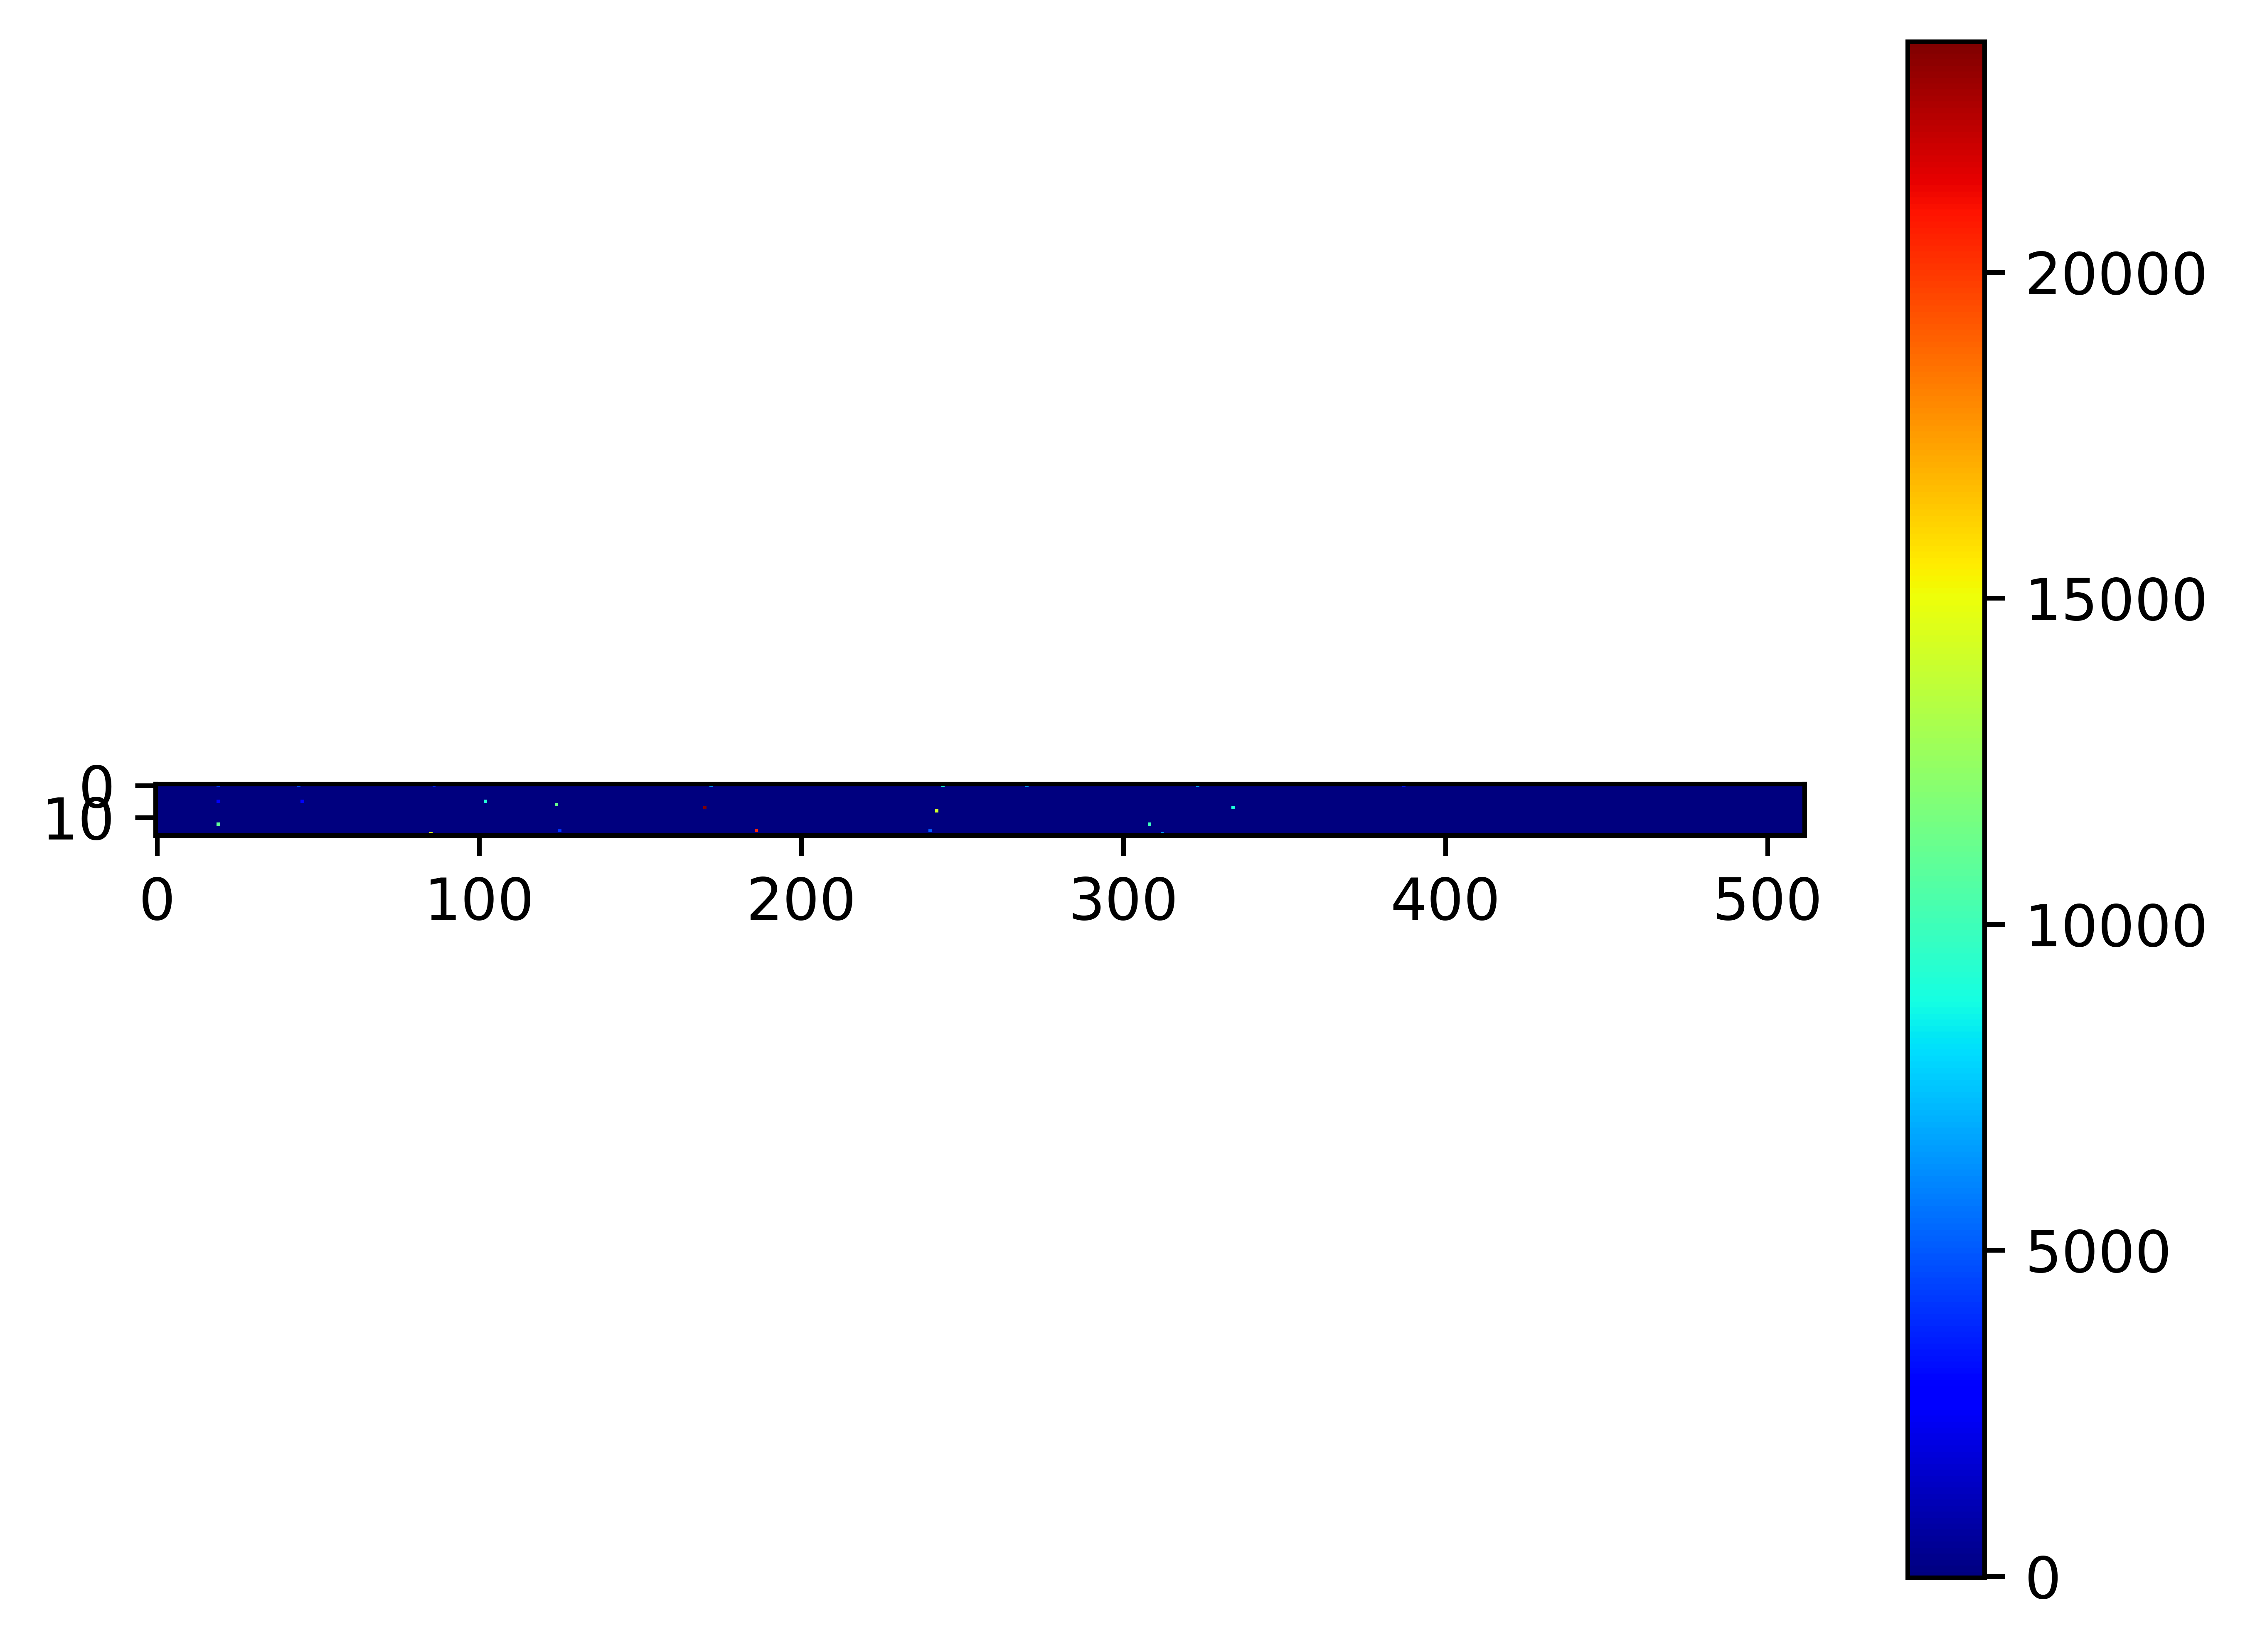

In [19]:
plt.figure(dpi=1000)
equal = torch.where(minused == 0.0, d1_data, 0.0)
plt.imshow(equal.squeeze(0).squeeze(0).detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()

In [28]:
threshold = 7000

In [29]:
index = torch.where(equal > threshold)

In [30]:
print(index)
print(len(index))

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), tensor([ 0,  5,  6,  7,  7,  8, 12, 12, 14, 15]), tensor([244, 102, 124, 170, 334, 242,  19, 308, 186,  85]))
4


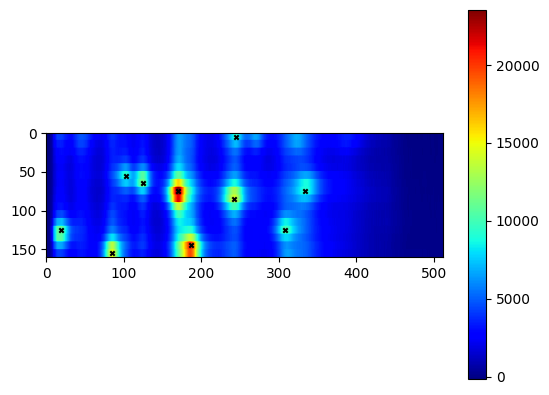

In [31]:
pltdata = []
for d in d1_data:
    for _ in range(10):
        pltdata.append(d)
plt.imshow(pltdata, cmap='jet')
plt.colorbar()

for i in range(len(index[0])):
    plt.scatter(index[3][i], index[2][i]*10+5, c='black', s=10, marker='x')